import library
check cuda is available
create class block and resnet

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from PIL import Image
from tqdm.auto import tqdm 
from timeit import default_timer as timer
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.__version__

'2.0.1'

In [3]:
!nvidia-smi

Fri Oct  4 16:53:55 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P3    12W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x




In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)






In [7]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [8]:
net = ResNet50(img_channel=3, num_classes=6).to(device)

In [9]:
d_Train="d:/kidney-disease-classification/archive/seg_train"
d_Test="d:/kidney-disease-classification/archive/seg_test"
d_pred="d:/kidney-disease-classification/archive/seg_pred"
train_dir = d_Train + "/seg_train"
test_dir = d_Test + "/seg_test/"
prediction_dir = d_pred + '/seg_pred'

In [10]:
train_dir

'd:/kidney-disease-classification/archive/seg_train/seg_train'

In [11]:
Image_path_Train = Path(train_dir)

In [12]:
def check_directory(directory_path):
                                 
    for dirpath , dirname , filename in os.walk(directory_path):
        print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

In [13]:
check_directory(Image_path_Train)

There are 6 directories and 0 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train'.
There are 0 directories and 2191 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train\buildings'.
There are 0 directories and 2271 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train\forest'.
There are 0 directories and 2404 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train\glacier'.
There are 0 directories and 2512 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train\mountain'.
There are 0 directories and 2274 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train\sea'.
There are 0 directories and 2382 images in 'd:\kidney-disease-classification\archive\seg_train\seg_train\street'.


In [14]:
Image_path_Test = Path(test_dir)
check_directory(Image_path_Test)

There are 6 directories and 0 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test'.
There are 0 directories and 437 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test\buildings'.
There are 0 directories and 474 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test\forest'.
There are 0 directories and 553 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test\glacier'.
There are 0 directories and 525 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test\mountain'.
There are 0 directories and 510 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test\sea'.
There are 0 directories and 501 images in 'd:\kidney-disease-classification\archive\seg_test\seg_test\street'.


In [161]:
Image_path_Test = Path(prediction_dir)
check_directory(Image_path_Test)

There are 0 directories and 7301 images in 'd:\kidney-disease-classification\archive\seg_pred\seg_pred'.


In [15]:
train_dir , test_dir , prediction_dir

('d:/kidney-disease-classification/archive/seg_train/seg_train',
 'd:/kidney-disease-classification/archive/seg_test/seg_test/',
 'd:/kidney-disease-classification/archive/seg_pred/seg_pred')

In [16]:
demo_img=train_dir+"/forest/5087.jpg"

In [17]:
demo_img=Path(demo_img)

In [18]:
img = Image.open(demo_img)

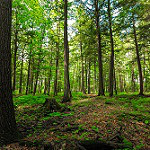

In [19]:
img

In [20]:
img.size

(150, 150)

In [21]:
img.format

'JPEG'

In [22]:
img.mode

'RGB'

In [23]:
img.getbands()

('R', 'G', 'B')

In [49]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(150 , 150)) ,
#    transforms.ColorJitter(0.4,0.5,0.5,0.2),
#    transforms.RandomHorizontalFlip(p=0.5) , 
    transforms.RandomCrop(size=(150,150)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [50]:
test_transforms = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [51]:
list_image_path = list(Path(train_dir).glob('*/*.jpg'))


In [52]:
list_image_path

[WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/0.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10006.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/1001.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10014.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10018.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10029.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10032.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10056.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/1009.jpg'),
 WindowsPath('d:/kidney-disease-classification/archive/seg_train/seg_train/buildings/10113.jpg'),
 WindowsPath('d:/kidney-di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


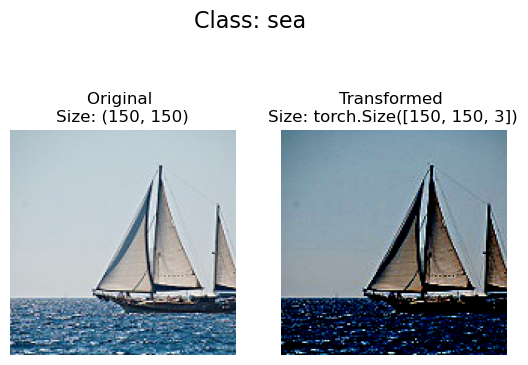

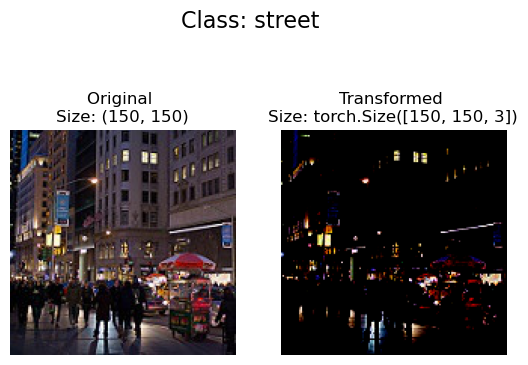

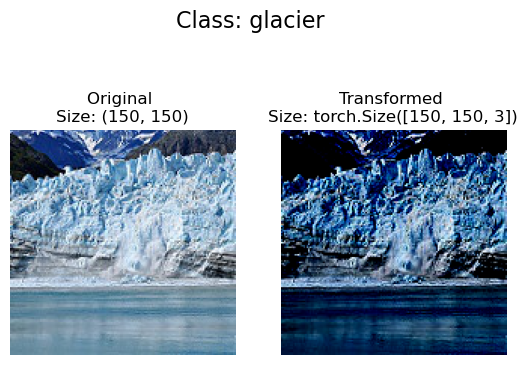

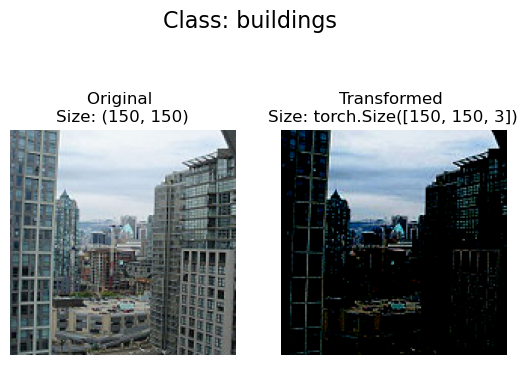

In [54]:
def show_transformed_images(path , transform , number=4 ,seed = 42):
    
    random.seed = seed
    random_image = random.sample(path , number)
    for path in random_image:
        with Image.open(path) as f :
            fig , ax = plt.subplots(1,2)      
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {path.parent.stem}", fontsize=16)
            
show_transformed_images(path=list_image_path , 
                        transform=test_transforms, 
                        number=4)

In [55]:
train_data = datasets.ImageFolder(root=train_dir , transform = train_transforms )
test_data = datasets.ImageFolder(root=test_dir , transform=test_transforms )
print(f'Train data : {train_data}\n\n\nTest data : {test_data}')

Train data : Dataset ImageFolder
    Number of datapoints: 14034
    Root location: d:/kidney-disease-classification/archive/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(150, 150), padding=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


Test data : Dataset ImageFolder
    Number of datapoints: 3000
    Root location: d:/kidney-disease-classification/archive/seg_test/seg_test/
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [56]:
def class_finder(directory):
    classes = sorted(i.name for i in os.scandir(directory) if i.is_dir())
    if not classes:
        raise FileNotFoundError(f'This directory dose not have any classes : {directory}')
    class_to_inx = {name : value for name , value in enumerate(classes) }
    
    return  classes , class_to_inx

In [57]:
class ImageFolderCustom(Dataset):
    
    
    def __init__(self , target_dir , transform ):
        
        self.paths = list(Path(target_dir).glob('*/*.jpg'))
        
        self.transform = transform
        
        self.classes , self.classes_to_inx = class_finder(target_dir)
    
    def load_image(self, index):
        
        image_path = self.paths[index]
        
        return Image.open(image_path)
    
    
    def __len__(self):
        
        return len(self.paths)
    
    
    
    def __getitem__(self , indx):
        
        img = self.load_image(indx)
        
        class_name = self.paths[indx].parent.name
        
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx

In [58]:
train_data_custom = ImageFolderCustom(target_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir= test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1221e8122d0>,
 <__main__.ImageFolderCustom at 0x122e0983790>)

In [59]:
print(f'The len of train data is : {len(train_data_custom)}\nThe len of test  data is : {len(test_data_custom)}')

The len of train data is : 14034
The len of test  data is : 3000


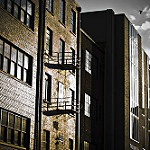

In [60]:
train_data_custom.load_image(100)

In [61]:
print(f'The number of classes are : {len(train_data_custom.classes)}')
train_data_custom.classes

The number of classes are : 6


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [62]:
train_data_custom.classes_to_inx

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [37]:
size_valid = 0.10


In [38]:
number_train = len(train_data_custom)
indx = list(range(number_train))
np.random.shuffle(indx)
split = int(size_valid * number_train)
train_idx, valid_idx = indx[split:], indx[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [80]:
number_train-number_train*0.1

12630.6

In [39]:
train_sampler

In [40]:
train_dataloader = DataLoader(dataset= train_data , 
                              batch_size= 32 ,  
                              num_workers=0,
                              sampler=train_sampler  
                              )
                             
valid_dataloader = DataLoader(dataset=train_data , 
                             batch_size=32 , 
                             num_workers=0,
                             sampler=valid_sampler                            
                             )

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=0,
                            shuffle=False)

In [41]:
img , label = next(iter(train_dataloader))
# img
print(f'The shape is : {img.shape} [batch-size , color-channels , height , width]')
print(f'The label shape is : {label.shape}')

The shape is : torch.Size([32, 3, 150, 150]) [batch-size , color-channels , height , width]
The label shape is : torch.Size([32])


In [109]:
type(img)

torch.Tensor

In [111]:
label[0]

tensor(2)

In [76]:
label.size

<function Tensor.size>

In [42]:
summary(net,(3,150,150),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 75, 75]           9,408
       BatchNorm2d-2           [32, 64, 75, 75]             128
              ReLU-3           [32, 64, 75, 75]               0
         MaxPool2d-4           [32, 64, 38, 38]               0
            Conv2d-5           [32, 64, 38, 38]           4,096
       BatchNorm2d-6           [32, 64, 38, 38]             128
              ReLU-7           [32, 64, 38, 38]               0
            Conv2d-8           [32, 64, 38, 38]          36,864
       BatchNorm2d-9           [32, 64, 38, 38]             128
             ReLU-10           [32, 64, 38, 38]               0
           Conv2d-11          [32, 256, 38, 38]          16,384
      BatchNorm2d-12          [32, 256, 38, 38]             512
           Conv2d-13          [32, 256, 38, 38]          16,384
      BatchNorm2d-14          [32, 256,

In [122]:
train_dataloader

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [68]:
model=net

In [69]:
train_loader=train_dataloader

In [82]:
val_loader=valid_dataloader

In [104]:
def train_model():
    EPOCHS = 15
    train_samples_num = 12630
    val_samples_num = 1404
    train_costs, val_costs = [], []
    
    #Training phase.    
    for epoch in range(EPOCHS):

        train_running_loss = 0
        correct_train = 0
        
        model.train().cuda()
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            """ for every mini-batch during the training phase, we typically want to explicitly set the gradients 
            to zero before starting to do backpropragation """
            optimizer.zero_grad()
            
            # Start the forward pass
            prediction = model(inputs)
                        
            loss = criterion(prediction, labels)
          
            # do backpropagation and update weights with step()
            loss.backward()         
            optimizer.step()
            
            # print('outputs on which to apply torch.max ', prediction)
            # find the maximum along the rows, use dim=1 to torch.max()
            _, predicted_outputs = torch.max(prediction.data, 1)
            
            # Update the running corrects 
            correct_train += (predicted_outputs == labels).float().sum().item()
            
            ''' Compute batch loss
            multiply each average batch loss with batch-length. 
            The batch-length is inputs.size(0) which gives the number total images in each batch. 
            Essentially I am un-averaging the previously calculated Loss '''
            train_running_loss += (loss.data.item() * inputs.shape[0])


        train_epoch_loss = train_running_loss / train_samples_num
        
        train_costs.append(train_epoch_loss)
        
        train_acc =  correct_train / train_samples_num

        # Now check trained weights on the validation set
        val_running_loss = 0
        correct_val = 0
      
        model.eval().cuda()
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = model(inputs)

                # Compute the loss.
                loss = criterion(prediction, labels)

                # Compute validation accuracy.
                _, predicted_outputs = torch.max(prediction.data, 1)
                correct_val += (predicted_outputs == labels).float().sum().item()

            # Compute batch loss.
            val_running_loss += (loss.data.item() * inputs.shape[0])

            val_epoch_loss = val_running_loss / val_samples_num
            val_costs.append(val_epoch_loss)
            val_acc =  correct_val / val_samples_num
        
        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        
        print(info.format(epoch+1, EPOCHS, train_epoch_loss, train_acc, val_epoch_loss, val_acc))
        
        torch.save(model.state_dict(), 'checkpoint_gpu_{}'.format(epoch + 1)) 
                                                                
    torch.save(model.state_dict(), 'resnet-50_weights_gpu')  
        
    return train_costs, val_costs

In [105]:
train_costs, val_costs = train_model()

[Epoch 1/15]: train-loss = 0.838082 | train-acc = 0.664 | val-loss = 0.017036 | val-acc = 0.689
[Epoch 2/15]: train-loss = 0.754941 | train-acc = 0.704 | val-loss = 0.014209 | val-acc = 0.700
[Epoch 3/15]: train-loss = 0.705592 | train-acc = 0.735 | val-loss = 0.010533 | val-acc = 0.702
[Epoch 4/15]: train-loss = 0.651018 | train-acc = 0.754 | val-loss = 0.016431 | val-acc = 0.754
[Epoch 5/15]: train-loss = 0.612179 | train-acc = 0.775 | val-loss = 0.010895 | val-acc = 0.728
[Epoch 6/15]: train-loss = 0.591482 | train-acc = 0.781 | val-loss = 0.020134 | val-acc = 0.697
[Epoch 7/15]: train-loss = 0.548511 | train-acc = 0.802 | val-loss = 0.013215 | val-acc = 0.780
[Epoch 8/15]: train-loss = 0.528600 | train-acc = 0.806 | val-loss = 0.006225 | val-acc = 0.757
[Epoch 9/15]: train-loss = 0.523766 | train-acc = 0.810 | val-loss = 0.012260 | val-acc = 0.783
[Epoch 10/15]: train-loss = 0.502896 | train-acc = 0.818 | val-loss = 0.010000 | val-acc = 0.762
[Epoch 11/15]: train-loss = 0.477577 | 

In [85]:
print(os.getcwd())

d:\kidney-disease-classification


In [ ]:
D:\kidney-disease-classification\content

In [107]:
test_loader=test_dataloader

In [108]:
test_samples_num = 3000
correct = 0 

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / test_samples_num
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.7906666666666666


In [300]:
pred_image=Image.open("archive/seg_pred/seg_pred/337.jpg")

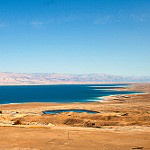

In [301]:
pred_image

In [302]:
trarm = transforms.Compose([
    transforms.PILToTensor()
])

In [303]:
img_tensor=trarm(pred_image)

In [304]:
a=test_transforms(pred_image)

In [305]:
a.shape

torch.Size([3, 150, 150])

In [306]:
a.shape

torch.Size([3, 150, 150])

In [307]:
a=a.float()

In [308]:
a=a.unsqueeze(0)

In [309]:
a.shape

torch.Size([1, 3, 150, 150])

In [310]:
x=model(a.to(device))

In [311]:
x

tensor([[-5.1508, -4.0988, -0.3378,  0.9124,  3.0783, -4.8243]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [312]:
_, predicted_class = torch.max(x.data, 1)

In [313]:
predicted_class

tensor([4], device='cuda:0')

In [314]:
{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}